In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
import requests
import spotipy
import lyricsgenius
import seaborn as sns
from spotipy.oauth2 import SpotifyClientCredentials
from scipy import stats
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Billboard Top 100 Data Exploration

In this project we will examine the Billboard Top 100 charts from 1970 to 2020. The goal will be to discover trends in the most popular music year over year. That is, the null hypothesis of this exploration will be that there is no consistent trend of music change year over year. Alternatively, we will be testing that such trends do exist. The metrics used to examine potential trends will be given by the Spotify audio analysis function. The function call returns the following key information:
> - **Instrumentalness:** This value represents the amount of vocals in the song. The closer it is to 1.0, the more instrumental the song is.
> - **Acousticness:** This value describes how acoustic a song is. A score of 1.0 means the song is most likely to be an acoustic one.
> - **Liveness:** This value describes the probability that the song was recorded with a live audience. According to the official documentation “a value above 0.8 provides strong likelihood that the track is live”.
> - **Speechiness:** “Speechiness detects the presence of spoken words in a track”. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.
> - **Energy:** “(energy) represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy”.
> - **Danceability:** “Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable”.
> - **Valence:** “A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)”.
> - **Key:**
> - **Loudness:**
> - **Tempo:**

### Establishing a connection with the Spotify API: 
> - The connection with the Spotify API will be made through the API wrapper, Spotipy. This will allow for easy function calls and data retreival. The following code snip will establish a connection wil the API using Spotipy's client credential manager along with credentials from my Spotify developer account.

#### Establish connection with API:

In [2]:
# client id:
client_id = 'aa3f1119fe2b4dca8a68a29b99c08b7d'

# client secret:
client_secret = '43400b9291384e5d8de6eb4d346bf466'

# initialize spotipy, the Spotify API wrapper: 
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Getting the data:
> The data will be gathered using user created playlists for each of the Billboard Top 100s since 1970. The playlist IDs are unique 22 digit strings of letters an numbers that the Spotify API uses to identify a playlist. These have been manually compiled in the 'Top_100_IDs.txt' file. We will iterate through the IDs and gather the associated information about the songs within. 

#### Make an array of all needed playlist IDs, these are in sorted order from 1970 to 2020: 

In [3]:
ids = []
with open('Top_100_IDs.txt') as f:
    ids = f.readlines()
for i in range(len(ids)): 
    ids[i] = ids[i].strip()

#### For each ID, find the data we need, frame it:

In [4]:
i = 0
frames = []
for y in range(1970, 2021):
    tracks = sp.playlist_tracks(ids[i])
    
    to_frame = []

    for track in tracks['items']:
        
        #ID
        track_id = (track["track"]["uri"]).split(':')[2]
    
        #Track name
        track_name = track["track"]["name"]
    
        #Main Artist
        artist_name = track["track"]["artists"][0]["name"]
        
        #if i == 0:
            #artist_uri = track["track"]["artists"][0]["uri"]
            #artist_info = sp.artist(artist_uri)
    
            #genre
            #artist_genres = artist_info["genres"]
            
        track_info = [y, track_name, track_id, artist_name]
        to_frame.append(track_info)

    arry = np.array(to_frame)
    df = pd.DataFrame(arry, columns=['year','track','track_ID','artist_name'])
    frames.append(df)
    i+=1

#### Let's have look a the complete dataframe:
> - We can see it contains the year, track name, track ID (from Spotify) and the artist name. All in order from 1970 to 2020. 

In [5]:
pd.set_option("display.max_rows", 20, "display.max_columns", 20)
all_data = pd.concat(frames)
all_data.reset_index()
#display(all_data)

,index,year,track,track_ID,artist_name
0,0,1970,Bridge Over Troubled Water,6l8EbYRtQMgKOyc1gcDHF9,Simon & Garfunkel
1,1,1970,(They Long To Be) Close To You,1DiP1KYlzeNysRN5JHLbfx,Carpenters
2,2,1970,American Woman,2FT4gakd3matx4vI6YCTD8,The Guess Who
3,3,1970,No Sugar Tonight / New Mother Nature,3WWi5DS9mnf9u9dgx5KntP,The Guess Who
4,4,1970,Raindrops Keep Fallin' On My Head - Rerecorded,53KvRwvw62Su6KCWUcK4OI,B.J. Thomas
...,...,...,...,...,...
5066,95,2020,More Than My Hometown,0eBXyY4SatzpE7opnzgXvz,Morgan Wallen
5067,96,2020,Lovin' On You,0nYvjcSlCgjcwogQAwIwNp,Luke Combs
5068,97,2020,Said Sum,3sKz6Sd72K0ofPWcJPPk6H,Moneybagg Yo
5069,98,2020,Slide,2rTnVB1bvwxHtaIl4uVu7f,H.E.R.


#### Let's see how many songs we have for each year:

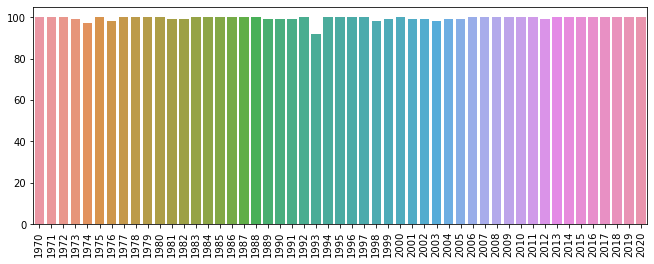

In [6]:
s = all_data['year'].value_counts()
s.sort_index(inplace=True)
plt.figure(figsize = (11,4))
ax = sns.barplot(x = s.index, y = s.values)
adj = plt.xticks(rotation = 90)

#### For each ID, frame the associated audio data:
> In order to gather the needed audio data, we will again be using Spotipy. The function call of particular interest is audio_features(). This will return the information described above in the project introduction. 

In [8]:
j = 0
for df in frames:
    danceability = []
    energy = []
    key = []
    loudness = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    for i,row in df.iterrows():
        audio_data = sp.audio_features([row['track_ID']])
        danceability.append(audio_data[0]['danceability'])
        energy.append(audio_data[0]['energy'])
        key.append(audio_data[0]['key'])
        loudness.append(audio_data[0]['loudness'])
        speechiness.append(audio_data[0]['speechiness'])
        acousticness.append(audio_data[0]['acousticness'])
        instrumentalness.append(audio_data[0]['instrumentalness'])
        liveness.append(audio_data[0]['liveness'])
        valence.append(audio_data[0]['valence'])
        tempo.append(audio_data[0]['tempo'])
    df['danceability'] = danceability
    df['energy'] = energy
    df['key'] = key
    df['loudness'] = loudness
    df['speechiness'] = speechiness
    df['acousticness'] = acousticness
    df['instrumentalness'] = instrumentalness
    df['liveness'] = liveness
    df['valence'] = valence
    df['tempo'] = tempo
    j += 1

In [56]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replicate this data fast:
> As to avoid the long computation time for the above data frame, we will export it to a csv file so that it can be imported quickly in the future. 

In [10]:
complete = pd.concat(frames)
complete.reset_index()
complete.to_csv('complete_data.csv')

#### break it into individual frames again for graphing:

In [16]:
complete_data = pd.read_csv('complete_data.csv')
imported_frames = []
i = 0
for year in range(1970, 2021): 
    imported_frames.append(complete_data.loc[complete_data['year'] == year])
    imported_frames[i] = imported_frames[i].drop(imported_frames[i].columns[0], axis = 1)
    imported_frames[i] = imported_frames[i].reset_index()
    i += 1

In [17]:
display(complete_data)

,Unnamed: 0,year,track,track_ID,artist_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0,1970,Bridge Over Troubled Water,6l8EbYRtQMgKOyc1gcDHF9,Simon & Garfunkel,0.149,0.206,3,-13.888,0.0323,0.82200,0.000649,0.1150,0.264,79.764
1,1,1970,(They Long To Be) Close To You,1DiP1KYlzeNysRN5JHLbfx,Carpenters,0.538,0.319,8,-10.631,0.0308,0.70800,0.000024,0.1320,0.217,89.068
2,2,1970,American Woman,2FT4gakd3matx4vI6YCTD8,The Guess Who,0.550,0.668,9,-11.090,0.0694,0.32700,0.000356,0.5030,0.341,93.587
3,3,1970,No Sugar Tonight / New Mother Nature,3WWi5DS9mnf9u9dgx5KntP,The Guess Who,0.513,0.832,1,-8.697,0.0447,0.55500,0.000028,0.3100,0.519,101.188
4,4,1970,Raindrops Keep Fallin' On My Head - Rerecorded,53KvRwvw62Su6KCWUcK4OI,B.J. Thomas,0.738,0.326,5,-13.487,0.0359,0.55600,0.000000,0.0685,0.794,110.861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5066,95,2020,More Than My Hometown,0eBXyY4SatzpE7opnzgXvz,Morgan Wallen,0.621,0.882,6,-5.010,0.0459,0.60100,0.000000,0.1320,0.574,126.014
5067,96,2020,Lovin' On You,0nYvjcSlCgjcwogQAwIwNp,Luke Combs,0.572,0.949,4,-4.865,0.0600,0.00165,0.000195,0.1630,0.530,118.974
5068,97,2020,Said Sum,3sKz6Sd72K0ofPWcJPPk6H,Moneybagg Yo,0.929,0.667,8,-6.789,0.3530,0.01850,0.000000,0.1000,0.274,126.998
5069,98,2020,Slide,2rTnVB1bvwxHtaIl4uVu7f,H.E.R.,0.832,0.469,10,-9.141,0.3390,0.08070,0.000008,0.2070,0.197,97.023


## Visualize the  Data:
> - Let's look at how danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveliness, valence and tempo have changed throughout the years. 

In [4]:
# create dataframe containing averages for each year
avgs = []
for df in imported_frames:
    year_stats = [df.loc[0,'year'], df['danceability'].mean(), df['energy'].mean(), df['key'].mean(), df['loudness'].mean(),
                  df['speechiness'].mean(), df['acousticness'].mean(), df['instrumentalness'].mean(),
                  df['liveness'].mean(), df['valence'].mean(), df['tempo'].mean()]
    avgs.append(year_stats)
    
    #df['year'] = pd.DatetimeIndex(df['year']).year

arry = np.array(avgs)
averages = pd.DataFrame(arry, columns = ['year', 'avg_danceability', 'avg_energy', 'avg_key', 'avg_loudness',
                                         'avg_speechiness', 'avg_acousticness', 'avg_instrumentalness', 
                                         'avg_liveness', 'avg_valence', 'avg_tempo'])

# make year a datetime object
#averages['year']= pd.DatetimeIndex(averages['year']).year

### Plot each of the characteristics:

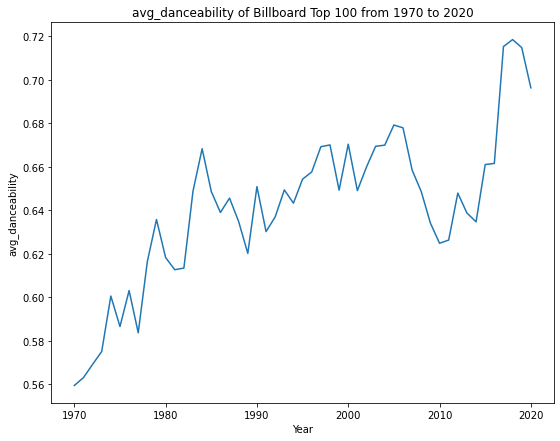

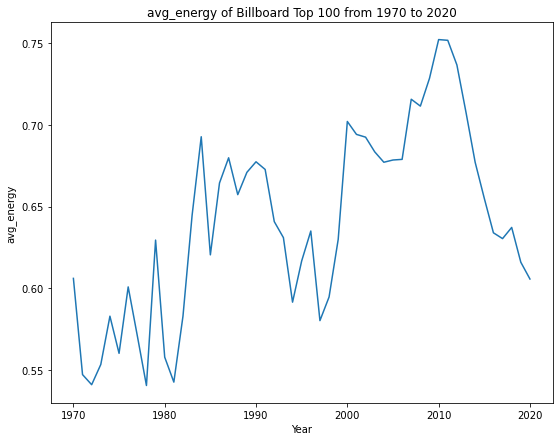

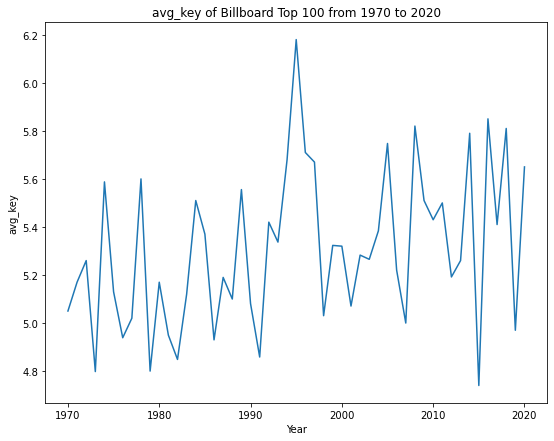

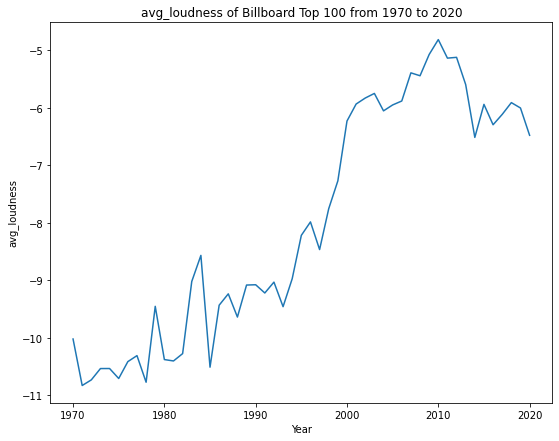

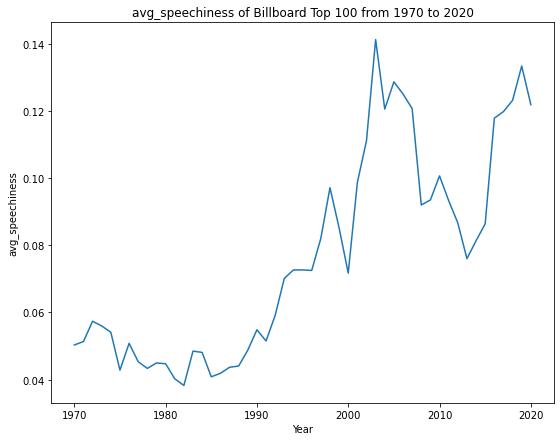

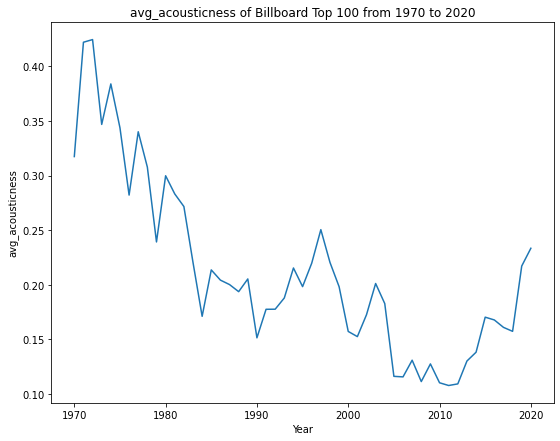

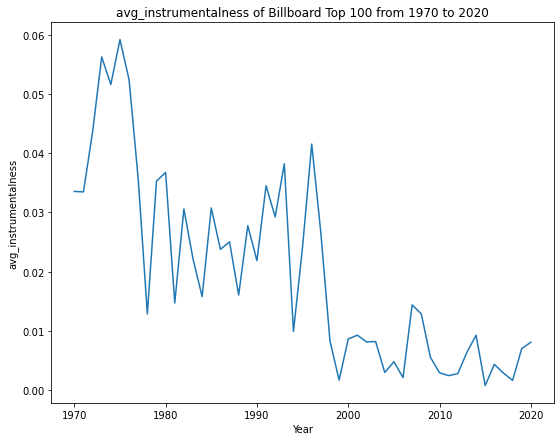

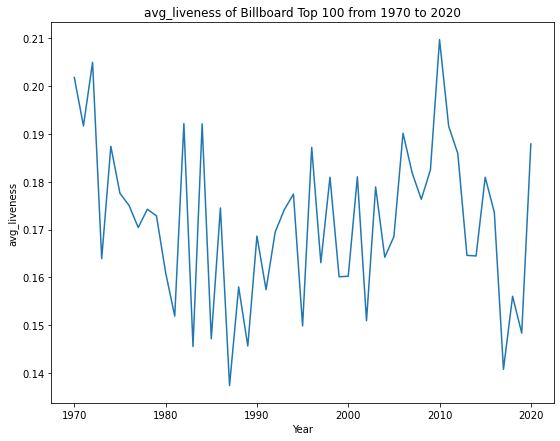

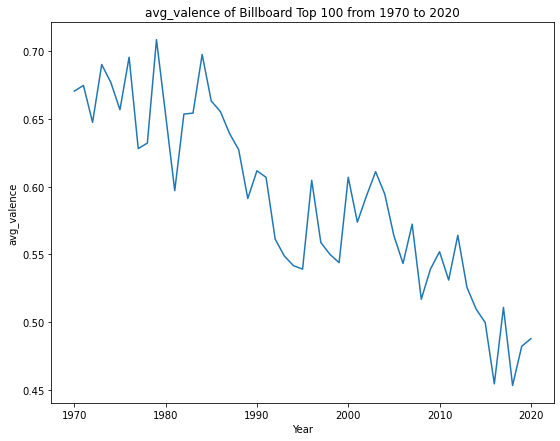

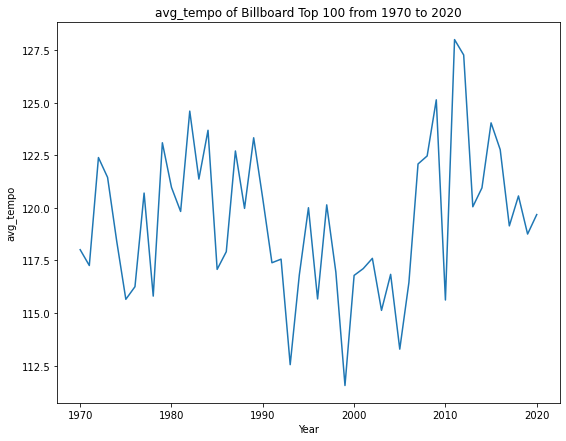

In [5]:
for cn,cd in averages.iteritems():
    if cn != 'year': 
        plt.figure(figsize = (9, 7))
        d = sns.lineplot(data = averages, x = 'year', y = cn)
        plt.title(cn + ' of Billboard Top 100 from 1970 to 2020')
        plt.xlabel('Year')
        plt.ylabel(cn)

#### Notes about the above graphs:
> - Average danceability looks to be generally increasing over the years, with a sharp decrease around 1990 and 2010. 
> - Average energy seems to peak around 1985 and again around 2010. It falls off sharply near 1998 and then again into 2020. 
> - **Average key is not usful.** 
> - Average loudness is increasing throughout the years. 
> - Average speechiness seems to peak around 2002 and 2019. A sharp decrease can be observed in 2014. 
> - Average acousticness is generally decreasing until 2010. The it begins to increase again. 
> - Average instrumentalness is generally decreasing.
> - **Average loudness is not useful.**
> - Average valence is decreasing over time. 
> - Average tempo shows a sharp increase around 2011

#### Questions to be asked: 
> - How is valence calculated? Is valence solely based on audio characteristics, or is lyric analysis also used? Could make a word cloud for 5 year intervals and analyze the seintiment of songs based on lyrics, and compare this to the valence over the same periods. This could disprove the null hypothesis by showing that people are listening to generally more negative sounding and meaning music. 

> - How has the most popular genre changed over time? What can be said about these genres, and the cooresponding danceability, valence, and energy. This could disprove the null hyptothesis by showing that genres have evolved over time (obviously), and the messages associated with these genres are significantly different. This then implies that people's taste in music has changed over time. 

> - What happened to instrumentalness? What genres are more popular now leading to the jurastic decrease?

## Analyzing Valence

#### The valence plot is interesting, lets have a closer look in the form of a linear regression plot: 

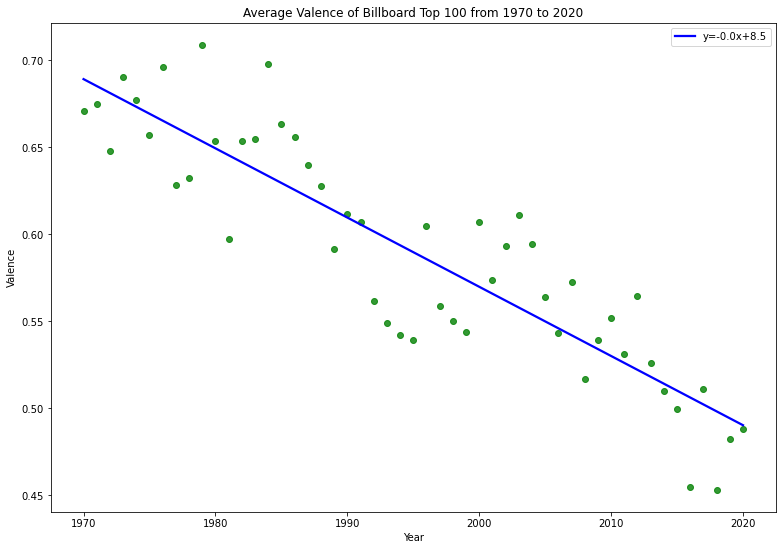

0.6890810590247192
0.4901349510284412


In [6]:
plt.figure(figsize = (13, 9))
#d = sns.regplot(data = averages, x = 'year', y = 'avg_valence', ci = None, 
                #scatter_kws={'color': 'green'}, line_kws={'color': 'pink'})

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(averages['year'],averages['avg_valence'])

# use line_kws to set line label for legend
ax = sns.regplot(x='year', y='avg_valence', data=averages, color='b', ci = None, scatter_kws={'color': 'green'},
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

#name the plot
plt.title('Average Valence of Billboard Top 100 from 1970 to 2020')
plt.xlabel('Year')
plt.ylabel('Valence')

# plot legend
ax.legend()

# show plot
plt.show()

start = (slope*1970)+intercept
end = (slope*2020)+intercept
print(start)
print(end)

#### Plot Description:
> - The plot above shows a steady decline in the valence, or positivity, of songs throughout the years based on auditory metrics. According to our linear regression, valence has decreased from approximately 0.68 in 1970, to 0.49 in 2020.

## Making word clouds:
> - In order to get a better idea of the decreasing valence over the years, we will construct word coulds over 5 year intervals. 
> - We will need the lyrics from the Top 100 songs. To get the lyrics, we will use the Genius Lyrics API. 

#### We will need the lyrics from the Billboard Top 100 songs:

In [7]:
# connect to the Genius API
f = open('genius_token.txt')  
token = f.readlines()[0]
gen = lyricsgenius.Genius(token)

#### See if we can get lyrics for all years:

In [13]:
#for frame in imported_frames:
for frame in imported_frames:
    frame['lyrics'] = np.nan
    print(frame.loc[0, 'year'])
    for i,row in frame.iterrows():
        while True:
            try: 
                song = gen.search_song(frame.loc[i,'track'], frame.loc[i,'artist_name'])
                j += 1
                break
            except: 
                pass
        if song != None:
            lyrics = (re.sub(r'[\(\[].*?[\)\]]', '', song.lyrics)).splitlines()
            lyrics.pop(0)
            lyrics = ' '.join(lyrics)
            frame.loc[i,'lyrics'] = lyrics

1970
Searching for "Bridge Over Troubled Water" by Simon & Garfunkel...
Done.
Searching for "(They Long To Be) Close To You" by Carpenters...
Done.
Searching for "American Woman" by The Guess Who...
Done.
Searching for "No Sugar Tonight / New Mother Nature" by The Guess Who...
Done.
Searching for "Raindrops Keep Fallin' On My Head - Rerecorded" by B.J. Thomas...
Done.
Searching for "War - Re-Recorded" by Edwin Starr...
No results found for: 'War - Re-Recorded Edwin Starr'
Searching for "Aint No Mountain High Enough" by Diana Ross...
Done.
Searching for "I'll Be There" by The Jackson 5...
Done.
Searching for "Get Ready - Single Version" by Rare Earth...
Done.
Searching for "Let It Be - Remastered" by The Beatles...
Done.
Searching for "Band Of Gold - Re-Record" by Freda Payne...
No results found for: 'Band Of Gold - Re-Record Freda Payne'
Searching for "Mama Told Me (Not To Come) - Single Version" by Three Dog Night...
Done.
Searching for "Everything Is Beautiful" by Ray Stevens...
Done

No results found for: 'Indian Reservation (Re-Recorded) Paul Revere & The Raiders'
Searching for "Go Away Little Girl" by Donny Osmond...
Done.
Searching for "Take Me Home, Country Roads - Rerecorded" by John Denver...
Done.
Searching for "Just My Imagination (Running Away With Me)" by The Temptations...
Done.
Searching for "Knock Three Times" by Tony Orlando & Dawn...
Done.
Searching for "Me and Bobby McGee" by The Full Tilt Boogie Band...
No results found for: 'Me and Bobby McGee The Full Tilt Boogie Band'
Searching for "Tired Of Being Alone" by Al Green...
Done.
Searching for "Want Ads" by Honey Cone...
Done.
Searching for "Smiling Faces Sometimes" by The Undisputed Truth...
Done.
Searching for "Treat Her Like A Lady" by Cornelius Brothers & Sister Rose...
Done.
Searching for "Brown Sugar - Remastered" by The Rolling Stones...
Done.
Searching for "You've Got A Friend" by James Taylor...
Done.
Searching for "Mr. Big Stuff" by Jean Knight...
Done.
Searching for "Do You Know What I Mea

Done.
Searching for "I'll Take You There" by The Staple Singers...
Done.
Searching for "Ben" by Michael Jackson...
Done.
Searching for "The Lion Sleeps Tonight" by Robert John...
Done.
Searching for "Outa-Space - Single Version" by Billy Preston...
No results found for: 'Outa-Space - Single Version Billy Preston'
Searching for "Slippin' Into Darkness" by War...
Done.
Searching for "Long Cool Woman (In a Black Dress) - 2003 Remaster" by The Hollies...
Done.
Searching for "How Do You Do?" by Mouth & MacNeal...
Done.
Searching for "A Horse with No Name - 2006 Remaster" by America...
Done.
Searching for "Song Sung Blue - Single Version" by Neil Diamond...
Done.
Searching for "Popcorn" by Hot Butter...
Specified song does not contain lyrics. Rejecting.
Searching for "Everybody Plays the Fool" by The Main Ingredient...
Done.
Searching for "Precious and Few - Rerecorded" by Climax...
Done.
Searching for "(Last Night) I Didn't Get To Sleep At All" by The 5th Dimension...
Done.
Searching for "N

Done.
Searching for "Danny's Song" by Anne Murray...
Done.
Searching for "Dancing In The Moonlight" by King Harvest...
Done.
Searching for "Monster Mash" by Bobby "Boris" Pickett & The Crypt-Kickers...
Done.
Searching for "Natural High - Single Version" by Bloodstone...
Done.
Searching for "Diamond Girl" by Seals and Crofts...
Done.
Searching for "Long Train Running" by The Doobie Brothers...
Done.
Searching for "Give Me Love (Give Me Peace On Earth)" by George Harrison...
Done.
Searching for "If You Want Me to Stay" by Sly & The Family Stone...
Done.
Searching for "Daddy's Home" by Jermaine Jackson...
Done.
Searching for "Neither One Of Us (Wants To Be The First To Say Goodbye)" by Gladys Knight & The Pips...
Done.
Searching for "I'm Doin' Fine Now" by New York City...
Done.
Searching for "Could It Be I'm Falling in Love" by The Spinners...
Done.
Searching for "Daniel" by Elton John...
Done.
Searching for "Midnight Train to Georgia" by Gladys Knight & The Pips...
Done.
Searching for "

Done.
Searching for "Hollywood Swinging" by Kool & The Gang...
Done.
Searching for "Be Thankful for What You Got" by William DeVaughn...
Done.
Searching for "Hang On In There Baby" by Johnny Bristol...
Done.
Searching for "Eres Tú" by Mocedades...
Done.
Searching for "Takin' Care Of Business" by Bachman-Turner Overdrive...
Done.
Searching for "Radar Love" by Golden Earring...
Done.
Searching for "Please Come to Boston" by Dave Loggins...
Done.
Searching for "Keep On Smilin'" by Wet Willie...
Done.
Searching for "Lookin' For A Love" by Bobby Womack...
Done.
Searching for "Put Your Hands Together" by The O'Jays...
Done.
Searching for "On and On" by Gladys Knight & The Pips...
Done.
Searching for "Oh Very Young" by Yusuf / Cat Stevens...
No results found for: 'Oh Very Young Yusuf / Cat Stevens'
Searching for "Leave Me Alone (Ruby Red Dress)" by Helen Reddy...
Done.
Searching for "Goodbye Yellow Brick Road - Remastered 2014" by Elton John...
Done.
Searching for "(I've Been) Searchin' So Lo

Done.
Searching for "Do It ('Til You're Satisfied)" by B.T. Express...
Done.
Searching for "Can't Get It out of My Head" by Electric Light Orchestra...
Done.
Searching for "Sha-La-La (Make Me Happy)" by Al Green...
Done.
Searching for "Lonely People" by America...
Done.
Searching for "You Got The Love" by Rufus & Chaka Khan...
Done.
Searching for "Theme from The Rockford Files (feat. Larry Carlton)" by Mike Post...
No results found for: 'Theme from The Rockford Files (feat. Larry Carlton) Mike Post'
Searching for "It Only Takes A Minute" by Tavares...
Done.
Searching for "No-No Song" by Ringo Starr...
Done.
Searching for "Junior's Farm" by Wings...
Done.
Searching for "Bungle in the Jungle" by Jethro Tull...
Done.
Searching for "Long Tall Glasses (I Can Dance) - Remastered" by Leo Sayer...
Done.
Searching for "Misty - 1975 #3Country; #14Pop Billboard chart hit" by Ray Stevens...
No results found for: 'Misty - 1975 #3Country; #14Pop Billboard chart hit Ray Stevens'
Searching for "Someon

Done.
Searching for "Junk Food Junkie" by Larry Groce...
Done.
Searching for "Tryin' to Get the Feeling Again" by Barry Manilow...
Done.
Searching for "Rock And Roll All Nite" by KISS...
Done.
Searching for "Take The Money And Run" by Steve Miller Band...
Done.
Searching for "Squeeze Box" by The Who...
Done.
Searching for "Country Boy (You Got Your Feet In L.A.)" by Glen Campbell...
Done.
1977
Searching for "Tonight's the Night (Gonna Be Alright) - 2009 Remaster" by Rod Stewart...
No results found for: 'Tonight's the Night (Gonna Be Alright) - 2009 Remaster Rod Stewart'
Searching for "I Just Want To Be Your Everything" by Andy Gibb...
Done.
Searching for "Best of My Love" by The Emotions...
Done.
Searching for "Evergreen (Love Theme from, "A Star Is Born")" by Barbra Streisand...
Done.
Searching for "Angel in Your Arms" by Hot...
Done.
Searching for "I Like Dreamin'" by Kenny Nolan...
Done.
Searching for "Don't Leave Me This Way - Single Version" by Thelma Houston...
Done.
Searching fo

Done.
Searching for "With A Little Luck - Remastered 1993" by Wings...
Done.
Searching for "If I Can't Have You - From "Saturday Night Fever"" by Yvonne Elliman...
No results found for: 'If I Can't Have You - From "Saturday Night Fever" Yvonne Elliman'
Searching for "Dance, Dance, Dance (Yowsah, Yowsah, Yowsah) - Edit" by CHIC...
No results found for: 'Dance, Dance, Dance (Yowsah, Yowsah, Yowsah) - Edit CHIC'
Searching for "Feels So Good - Single Version" by Chuck Mangione...
Done.
Searching for "Hot Child in the City - Extended Remix" by Nick Gilder...
No results found for: 'Hot Child in the City - Extended Remix Nick Gilder'
Searching for "Love Is Like Oxygen" by Sweet...
Done.
Searching for "It's a Heartache" by Bonnie Tyler...
Done.
Searching for "We Will Rock You" by Queen...
Done.
Searching for "We Are The Champions" by Queen...
Done.
Searching for "Baker Street" by Gerry Rafferty...
Done.
Searching for "Can't Smile Without You" by Barry Manilow...
Done.
Searching for "Too Much, 

Done.
Searching for "Mama Can't Buy You Love" by Elton John...
Done.
Searching for "I Was Made for Dancin'" by Leif Garrett...
Done.
Searching for "After The Love Has Gone" by Earth, Wind & Fire...
Done.
Searching for "Heaven Knows" by Donna Summer...
Done.
Searching for "The Gambler" by Kenny Rogers...
Done.
Searching for "Lotta Love" by Nicolette Larson...
Done.
Searching for "Lady" by Little River Band...
Done.
Searching for "Heaven Must Have Sent You - 12" Version" by Bonnie Pointer...
Done.
Searching for "Hold the Line" by TOTO...
Done.
Searching for "He's the Greatest Dancer - Remaster" by Sister Sledge...
Done.
Searching for "Sharing The Night Together" by Dr. Hook...
Done.
Searching for "She Believes In Me" by Kenny Rogers...
Done.
Searching for "In The Navy" by Village People...
Done.
Searching for "Music Box Dancer" by Frank Mills...
Specified song does not contain lyrics. Rejecting.
Searching for "The Devil Went Down To Georgia" by The Charlie Daniels Band...
Done.
Searching

Done.
Searching for "Cool Change" by Little River Band...
Done.
Searching for "You're Only Lonely" by JD Souther...
Done.
Searching for "Desire" by Andy Gibb...
Done.
Searching for "Let My Love Open The Door" by Pete Townshend...
Done.
Searching for "Romeo's Tune" by Steve Forbert...
Done.
Searching for "Daydream Believer" by Anne Murray...
Done.
Searching for "I Can't Tell You Why - 2013 Remaster" by Eagles...
Done.
Searching for "Don't Let Go" by Isaac Hayes...
Done.
Searching for "Don't Do Me Like That" by Tom Petty and the Heartbreakers...
Done.
Searching for "She's Out of My Life - Single Version" by Michael Jackson...
Done.
Searching for "Fame" by Irene Cara...
Done.
Searching for "Fire Lake" by Bob Seger...
Done.
Searching for "How Do I Make You" by Linda Ronstadt...
Done.
Searching for "Into The Night (Re-Recorded In Stereo)" by Benny Mardones...
No results found for: 'Into The Night (Re-Recorded In Stereo) Benny Mardones'
Searching for "Let Me Love You Tonight" by Pure Prairie

Done.
Searching for "Step By Step" by Eddie Rabbitt...
Done.
Searching for "The Stroke" by Billy Squier...
Done.
Searching for "Feels So Right" by Alabama...
Done.
Searching for "Sweet Baby" by Stanley Clarke...
Done.
Searching for "Same Old Lang Syne" by Dan Fogelberg...
Done.
Searching for "Cool Love" by Pablo Cruise...
Done.
Searching for "Hold On Tight" by Electric Light Orchestra...
Done.
Searching for "Treat Me Right" by Pat Benatar...
Done.
Searching for "Winning" by Santana...
Done.
Searching for "What Kind of Fool (feat. Barry Gibb)" by Barbra Streisand...
Done.
Searching for "Watching The Wheels - Remastered 2010" by John Lennon...
No results found for: 'Watching The Wheels - Remastered 2010 John Lennon'
Searching for "Tell It Like It Is" by Heart...
Done.
Searching for "Smoky Mountain Rain" by Ronnie Milsap...
Done.
Searching for "I Made It Through the Rain" by Barry Manilow...
Done.
Searching for "You've Lost That Lovin' Feeling" by Daryl Hall & John Oates...
Done.
Searchin

Done.
Searching for "Through The Years - Single Version" by Kenny Rogers...
Done.
Searching for "Edge of Seventeen - 2016 Remaster" by Stevie Nicks...
Done.
1983
Searching for "Every Breath You Take" by The Police...
Done.
Searching for "Billie Jean - Single Version" by Michael Jackson...
Done.
Searching for "Flashdance...What A Feeling" by Irene Cara...
Done.
Searching for "Down Under" by Men At Work...
Done.
Searching for "Beat It" by Michael Jackson...
Done.
Searching for "Total Eclipse of the Heart" by Bonnie Tyler...
Searching for "Total Eclipse of the Heart" by Bonnie Tyler...
Searching for "Total Eclipse of the Heart" by Bonnie Tyler...
Done.
Searching for "Maneater" by Daryl Hall & John Oates...
Done.
Searching for "Baby, Come To Me" by Patti Austin...
Done.
Searching for "Maniac" by Michael Sembello...
Done.
Searching for "Sweet Dreams (Are Made of This) - Remastered" by Eurythmics...
No results found for: 'Sweet Dreams (Are Made of This) - Remastered Eurythmics'
Searching for

Done.
Searching for "Let's Hear It For The Boy" by Deniece Williams...
Done.
Searching for "Dancing In The Dark" by Bruce Springsteen...
Done.
Searching for "Girls Just Want to Have Fun" by Cyndi Lauper...
Done.
Searching for "The Reflex - 2010 Remaster" by Duran Duran...
Done.
Searching for "Time After Time" by Cyndi Lauper...
Done.
Searching for "Jump (For My Love) - Single Remix" by The Pointer Sisters...
Done.
Searching for "Talking in Your Sleep" by The Romantics...
Done.
Searching for "Self Control" by Laura Branigan...
Done.
Searching for "Let's Go Crazy - 2015 Paisley Park Remaster" by Prince...
No results found for: 'Let's Go Crazy - 2015 Paisley Park Remaster Prince'
Searching for "Say It Isn't So" by Daryl Hall & John Oates...
Done.
Searching for "Hold Me Now" by Thompson Twins...
Done.
Searching for "Joanna" by Kool & The Gang...
Done.
Searching for "I Just Called To Say I Love You" by Stevie Wonder...
Done.
Searching for "Somebody's Watching Me" by Rockwell...
Done.
Search

Done.
Searching for "Cool It Now" by New Edition...
Done.
Searching for "Miami Vice Theme" by Jan Hammer...
Done.
Searching for "Loverboy" by Billy Ocean...
Done.
Searching for "Lovergirl" by Teena Marie...
Done.
Searching for "You Belong To The City" by Glenn Frey...
Done.
Searching for "Oh Sheila" by Ready For The World...
Done.
Searching for "Rhythm Of The Night" by DeBarge...
Done.
Searching for "One More Night" by Phil Collins...
Done.
Searching for "Sea of Love - 2006 Remaster" by The Honeydrippers...
No results found for: 'Sea of Love - 2006 Remaster The Honeydrippers'
Searching for "A View to a Kill" by Duran Duran...
Done.
Searching for "The Wild Boys - Live at Oakland Coliseum, Oakland, CA, 14/04/1984; 2004 Remaster" by Duran Duran...
No results found for: 'The Wild Boys - Live at Oakland Coliseum, Oakland, CA, 14/04/1984; 2004 Remaster Duran Duran'
Searching for "You're the Inspiration - 2003 Remaster" by Chicago...
Done.
Searching for "Neutron Dance" by The Pointer Sisters.

Done.
Searching for "Manic Monday" by The Bangles...
Done.
Searching for "Walk of Life" by Dire Straits...
Done.
Searching for "Amanda" by Boston...
Done.
Searching for "Two of Hearts" by Stacey Q...
Done.
Searching for "Crush On You" by The Jets...
Done.
Searching for "If You Leave - From "Pretty In Pink"" by Orchestral Manoeuvres In The Dark...
Done.
Searching for "Invisible Touch - 2007 Remaster" by Genesis...
Done.
Searching for "The Sweetest Taboo - Remastered" by Sade...
Done.
Searching for "What You Need" by INXS...
Done.
Searching for "Talk to Me" by Stevie Nicks...
Done.
Searching for "Nasty" by Janet Jackson...
Done.
Searching for "Take Me Home Tonight" by Eddie Money...
Done.
Searching for "We Don't Have To Take Our Clothes Off" by Jermaine Stewart...
Done.
Searching for "All Cried Out (with Full Force)" by Lisa Lisa & Cult Jam...
Done.
Searching for "Your Love" by The Outfield...
Done.
Searching for "I'm Your Man" by Wham!...
Done.
Searching for "Perfect Way" by Scritti Pol

Done.
Searching for "Rhythm Is Gonna Get You" by Gloria Estefan And Miami Sound Machine...
Done.
Searching for "Rock Steady" by The Whispers...
Done.
Searching for "Wanted Dead Or Alive" by Bon Jovi...
Done.
Searching for "Big Time (feat. Peter Gabriel & Electrokingdom) - Radio Edit UK" by Hardage...
No results found for: 'Big Time (feat. Peter Gabriel & Electrokingdom) - Radio Edit UK Hardage'
Searching for "The Finer Things" by Steve Winwood...
Done.
Searching for "Let Me Be The One" by Exposé...
Done.
Searching for "Is This Love" by Survivor...
Done.
Searching for "Diamonds" by Herb Alpert With Janet Jackson...
Done.
Searching for "Point of No Return - 7" Version" by Exposé...
Done.
Searching for "Big Love" by Fleetwood Mac...
Done.
Searching for "Midnight Blue" by Lou Gramm...
Done.
Searching for "Something So Strong" by Crowded House...
Done.
Searching for "Heat Of The Night" by Bryan Adams...
Done.
Searching for "Nothing's Gonna Change My Love for You" by Glenn Medeiros...
Done.


Done.
Searching for "Cherry Bomb" by John Mellencamp...
Done.
Searching for "I Still Believe - English Version" by Brenda K. Starr...
Done.
Searching for "I Found Someone" by Cher...
Done.
Searching for "Never Tear Us Apart" by INXS...
Done.
Searching for "Valerie" by Steve Winwood...
Done.
Searching for "Just Like Paradise" by David Lee Roth...
Done.
Searching for "Nothin' But A Good Time - Remastered 2006" by Poison...
Done.
Searching for "Wait" by White Lion...
Done.
Searching for "Prove Your Love" by Taylor Dayne...
Done.
1989
Searching for "Look Away - 2009 Remaster" by Chicago...
Done.
Searching for "My Prerogative" by Bobby Brown...
Done.
Searching for "Every Rose Has Its Thorn - Remastered 2003" by Poison...
Done.
Searching for "Straight Up" by Paula Abdul...
Done.
Searching for "Miss You Much" by Janet Jackson...
Done.
Searching for "Cold Hearted" by Paula Abdul...
Done.
Searching for "Wind Beneath My Wings" by Bette Midler...
Done.
Searching for "Girl You Know It's True" by M

Done.
Searching for "I Wanna Be Rich" by Calloway...
Done.
Searching for "Rub You The Right Way - Radio Edit" by Johnny Gill...
Done.
Searching for "She Ain't Worth It" by Glenn Medeiros...
Done.
Searching for "If Wishes Came True" by Sweet Sensation...
Done.
Searching for "The Power" by SNAP!...
Done.
Searching for "(Can't Live Without Your) Love And Affection - Remastered 2017" by Nelson...
No results found for: '(Can't Live Without Your) Love And Affection - Remastered 2017 Nelson'
Searching for "Love Will Lead You Back" by Taylor Dayne...
Done.
Searching for "Don't Wanna Fall in Love" by Jane Child...
Done.
Searching for "Two To Make It Right" by Seduction...
Done.
Searching for "Sending All My Love" by Linear...
Done.
Searching for "Unskinny Bop" by Poison...
Done.
Searching for "Step by Step" by New Kids On The Block...
Done.
Searching for "Dangerous" by Roxette...
Done.
Searching for "We Didn't Start the Fire" by Billy Joel...
Done.
Searching for "I Don't Have The Heart" by Jame

No results found for: 'Things That Make You Go Hmmmm.... (feat. Freedom Williams) C & C Music Factory'
Searching for "I Touch Myself" by Divinyls...
Done.
Searching for "Tom's Diner" by Suzanne Vega...
Done.
Searching for "Iesha" by Another Bad Creation...
Done.
Searching for "Something To Talk About" by Bonnie Raitt...
Done.
Searching for "After The Rain" by Nelson...
Done.
Searching for "Play That Funky Music" by Vanilla Ice...
Done.
Searching for "Temptation" by Corina...
Done.
Searching for "Can't Stop This Thing We Started" by Bryan Adams...
Done.
Searching for "I Can't Wait Another Minute" by Hi-Five...
Done.
Searching for "3 A.M. Eternal" by The KLF...
Done.
Searching for "Time, Love And Tenderness - Single Version" by Michael Bolton...
Done.
Searching for "Sadeness - Pt. 1 / Radio Edit" by Enigma...
No results found for: 'Sadeness - Pt. 1 / Radio Edit Enigma'
Searching for "Around The Way Girl" by LL Cool J...
Done.
Searching for "I'll Be There" by The Escape Club...
Done.
Sear

Done.
Searching for "Addams Groove" by MC Hammer...
Done.
Searching for "Missing You Now (feat. Kenny G)" by Michael Bolton...
Done.
Searching for "Back to the Hotel" by N2DEEP...
Done.
Searching for "Everything Changes" by Kathy Troccoli...
Done.
Searching for "Have You Ever Needed Someone So Bad" by Def Leppard...
Done.
Searching for "Take This Heart" by Richard Marx...
Done.
Searching for "When I Look Into Your Eyes" by Firehouse...
Done.
Searching for "I Wanna Love You" by Jade...
Done.
Searching for "Uhh Ahh" by Boyz II Men...
Done.
Searching for "Real Love" by Mary J. Blige...
Done.
Searching for "Justified & Ancient" by The KLF...
Done.
Searching for "Slow Motion" by Color Me Badd...
Done.
Searching for "What About Your Friends" by TLC...
Done.
Searching for "Thinkin' Back" by Color Me Badd...
Done.
Searching for "Would I Lie To You?" by Charles & Eddie...
Done.
Searching for "That's What Love Is For" by Amy Grant...
Done.
Searching for "Keep Coming Back" by Richard Marx...
Done

Done.
Searching for "Fantastic Voyage" by Coolio...
Done.
Searching for "Baby, I Love Your Way" by Big Mountain...
Done.
Searching for "Regulate" by Warren G...
Done.
Searching for "If You Go" by Jon Secada...
Done.
Searching for "Back & Forth" by Aaliyah...
Done.
Searching for "Now And Forever" by Richard Marx...
Done.
Searching for "When Can I See You" by Babyface...
Done.
Searching for "Please Forgive Me" by Bryan Adams...
Done.
Searching for "So Much in Love" by All-4-One...
Done.
Searching for "Shoop" by Salt-N-Pepa...
Done.
Searching for "Any Time, Any Place" by Janet Jackson...
Done.
Searching for "Shine" by Collective Soul...
Done.
Searching for "Said I Loved You...But I Lied" by Michael Bolton...
Done.
Searching for "Return To Innocence" by Enigma...
Done.
Searching for "All I Wanna Do" by Sheryl Crow...
Done.
Searching for "Mmm Mmm Mmm Mmm" by Crash Test Dummies...
Done.
Searching for "Can We Talk" by Tevin Campbell...
Done.
Searching for "Funkdafied" by Da Brat...
Done.
Sear

Done.
Searching for "Roll To Me" by Del Amitri...
Done.
Searching for "Scream" by Michael Jackson...
Done.
Searching for "Freek'n You" by Jodeci...
Done.
Searching for "I Wish" by Skee-Lo...
Done.
Searching for "Believe - Radio Edit" by Elton John...
Done.
Searching for "Carnival" by Natalie Merchant...
Done.
Searching for "You Don't Know How It Feels" by Tom Petty...
Done.
Searching for "Back for Good - Radio Mix" by Take That...
Done.
Searching for "Tootsee Roll" by 69 Boyz...
Done.
Searching for "You Want This" by Janet Jackson...
Done.
Searching for "Tell Me" by Groove Theory...
Done.
Searching for "Can't You See" by Total...
Done.
Searching for "All I Wanna Do" by Sheryl Crow...
Done.
Searching for "This Lil' Game We Play" by Subway...
Done.
Searching for "Come and Get Your Love - Radio Edit" by Real McCoy...
Done.
Searching for "This Ain't A Love Song" by Bon Jovi...
Done.
Searching for "Secret" by Madonna...
Done.
Searching for "Player's Anthem" by Junior M.A.F.I.A....
Done.
Sea

No results found for: 'Mission Impossible - Main Theme Danny Elfman'
Searching for "Closer to Free" by Bodeans...
Done.
Searching for "Just A Girl" by No Doubt...
Done.
Searching for "If Your Girl Only Knew [In the Style of "Aaliyah"]" by Done Again...
Done.
Searching for "Lady" by D'Angelo...
Done.
Searching for "Key West Intermezzo (I Saw You First)" by John Mellencamp...
Done.
Searching for "Pony" by Ginuwine...
Done.
Searching for "Nobody (feat. Athena Cage) - Single Version; 2007 Remaster" by Keith Sweat...
No results found for: 'Nobody (feat. Athena Cage) - Single Version; 2007 Remaster Keith Sweat'
Searching for "Old Man & Me" by Hootie & The Blowfish...
Done.
Searching for "If It Makes You Happy" by Sheryl Crow...
Done.
Searching for "As I Lay Me Down" by Sophie B. Hawkins...
Done.
Searching for "Keep On, Keepin' On (feat. Xscape)" by MC Lyte...
Done.
Searching for "Jealousy" by Natalie Merchant...
Done.
Searching for "I Want To Come Over" by Melissa Etheridge...
Done.
Searchin

Done.
Searching for "Let It Flow - from "Waiting to Exhale" Original Soundtrack" by Toni Braxton...
No results found for: 'Let It Flow - from "Waiting to Exhale" Original Soundtrack Toni Braxton'
Searching for "You Must Love Me" by Madonna...
Done.
1998
Searching for "Too Close" by Next...
Done.
Searching for "The Boy Is Mine" by Brandy...
Done.
Searching for "You're Still The One" by Shania Twain...
Done.
Searching for "Truly Madly Deeply" by Savage Garden...
Done.
Searching for "How Do I Live" by LeAnn Rimes...
Done.
Searching for "Together Again" by Janet Jackson...
Done.
Searching for "All My Life" by K-Ci & JoJo...
Done.
Searching for "Candle In The Wind" by Elton John...
Done.
Searching for "Nice & Slow - Radio Version" by Usher...
Done.
Searching for "I Don't Want to Wait" by Paula Cole...
Done.
Searching for "How's It Going to Be" by Third Eye Blind...
Done.
Searching for "No, No, No, Pt. 1" by Destiny's Child...
Done.
Searching for "No, No, No Pt. 2 (feat. Wyclef Jean)" by Des

Done.
Searching for "Someday" by Sugar Ray...
Done.
Searching for "That Don't Impress Me Much" by Shania Twain...
Done.
Searching for "Wild Wild West (feat. Dru Hill & Kool Mo Dee) - Album Version With Intro" by Will Smith...
Done.
Searching for "Scar Tissue" by Red Hot Chili Peppers...
Done.
Searching for "Heartbreaker (feat. Jay-Z)" by Mariah Carey...
Done.
Searching for "I Still Believe" by Mariah Carey...
Done.
Searching for "The Hardest Thing" by 98º...
No results found for: 'The Hardest Thing 98º'
Searching for "Summer Girls" by LFO...
Done.
Searching for "Can I Get A... - From The Rush Hour Soundtrack" by JAY-Z...
Done.
Searching for "Jumper - 1998 Edit" by Third Eye Blind...
Done.
Searching for "Doo Wop (That Thing)" by Ms. Lauryn Hill...
Done.
Searching for "Mambo No. 5 (a Little Bit of...)" by Lou Bega...
Done.
Searching for "Sweet Lady" by Tyrese...
Done.
Searching for "It's Not Right But It's Okay" by Whitney Houston...
Done.
Searching for "(God Must Have Spent) A Little Mo

Done.
Searching for "You Know" by Donell Jones...
Done.
Searching for "Only God Knows Why" by Kid Rock...
Done.
Searching for "Shake Ya Ass" by Mystikal...
Done.
Searching for "Bag Lady" by Erykah Badu...
Done.
Searching for "Meet Virginia" by Train...
Done.
Searching for "Party Up" by DMX...
Done.
Searching for "Case Of The Ex" by Mýa...
Done.
Searching for "Forgot About Dre" by Dr. Dre...
Done.
Searching for "That's The Way" by Jo Dee Messina...
Done.
Searching for "Swear It Again" by MyLove...
Done.
Searching for "The Next Episode" by Dr. Dre...
Done.
Searching for "From the Bottom of My Broken Heart" by Britney Spears...
Done.
Searching for "Crash and Burn" by Savage Garden...
Done.
Searching for "Yes!" by Chad Brock...
Done.
Searching for "The Best Day" by George Strait...
Done.
Searching for "Where I Wanna Be" by Donell Jones...
Done.
Searching for "How Do You Like Me Now?!" by Toby Keith...
Done.
Searching for "My Best Friend" by Tim McGraw...
Done.
Searching for "Broadway" by T

Done.
Searching for "Complicated" by Avril Lavigne...
Done.
Searching for "Always On Time" by Ja Rule...
Done.
Searching for "Ain't It Funny (feat. Ja Rule & Cadillac Tah) - Murder Remix" by Jennifer Lopez...
Done.
Searching for "The Middle" by Jimmy Eat World...
Done.
Searching for "I Need a Girl (Pt. 1) [feat. Usher & Loon]" by Diddy...
Done.
Searching for "U Don't Have to Call" by Usher...
Done.
Searching for "Family Affair" by Mary J. Blige...
Done.
Searching for "I Need a Girl (Pt. 2) [feat. Ginuwine, Loon, Mario Winans & Tammy Ruggieri] - 2016 Remaster" by Diddy...
No results found for: 'I Need a Girl (Pt. 2) [feat. Ginuwine, Loon, Mario Winans & Tammy Ruggieri] - 2016 Remaster Diddy'
Searching for "Gangsta Lovin'" by Eve...
Done.
Searching for "My Sacrifice" by Creed...
Done.
Searching for "Without Me" by Halsey...
Done.
Searching for "Hero" by Enrique Iglesias...
Done.
Searching for "All You Wanted" by Michelle Branch...
Done.
Searching for "Get the Party Started" by P!nk...
Do

Done.
Searching for "Never Leave You (Uh Oooh, Uh Oooh)" by Lumidee...
Done.
Searching for "Beautiful" by Snoop Dogg...
Done.
Searching for "Gossip Folks (feat. Ludacris)" by Missy Elliott...
Done.
Searching for "Miss Independent" by Kelly Clarkson...
Done.
Searching for "Calling All Angels" by Train...
Done.
Searching for "Damn! (feat. Lil' Jon) - Club Mix" by Youngbloodz...
Done.
Searching for "This Is the Night" by Ameritz Tribute Standards...
No results found for: 'This Is the Night Ameritz Tribute Standards'
Searching for "Your Body Is a Wonderland" by John Mayer...
Done.
Searching for "Headstrong" by Trapt...
Done.
Searching for "In Those Jeans" by Ginuwine...
Done.
Searching for "Stand Up" by Ludacris...
Done.
Searching for "The Remedy (I Won't Worry)" by Jason Mraz...
Done.
Searching for "Why Don't You & I (feat. Alex Band) - Alt. Version" by Santana...
Done.
Searching for "Excuse Me Miss" by JAY-Z...
Done.
Searching for "Jenny from the Block - Track Masters Remix featuring Sty

Done.
Searching for "Step in the Name of Love - Remix - Radio Edit" by R. Kelly...
Done.
Searching for "Breaking the Habit" by Linkin Park...
Done.
Searching for "Gigolo (feat. R. Kelly)" by Nick Cannon...
Done.
Searching for "Live Like You Were Dying" by Tim McGraw...
Done.
Searching for "Remember When" by Alan Jackson...
Done.
Searching for "Everytime" by Britney Spears...
Done.
Searching for "Southside" by Lloyd...
Done.
Searching for "Dude" by Beenie Man...
Done.
Searching for "Wanna Get To Know You" by G-Unit...
Done.
Searching for "Holidae In" by Chingy...
Done.
Searching for "Let's Get It Started" by Black Eyed Peas...
Done.
Searching for "When the Sun Goes Down" by Kenny Chesney...
Done.
Searching for "American Soldier" by Toby Keith...
Done.
Searching for "Don't Tell Me" by Avril Lavigne...
Done.
Searching for "You'll Think Of Me - Single Version" by Keith Urban...
Done.
Searching for "Happy People" by R. Kelly...
Done.
Searching for "Hey Mama" by Black Eyed Peas...
Done.
Sear

Done.
Searching for "What Hurts The Most" by Rascal Flatts...
Done.
Searching for "How to Save a Life" by The Fray...
Done.
Searching for "Unfaithful" by Rihanna...
Done.
Searching for "Chasing Cars" by Snow Patrol...
Done.
Searching for "Lips Of An Angel" by Hinder...
Done.
Searching for "Everytime We Touch" by Cascada...
Done.
Searching for "Ain't No Other Man" by Christina Aguilera...
Done.
Searching for "Dance, Dance" by Fall Out Boy...
Done.
Searching for "Gold Digger" by Kanye West...
Done.
Searching for "Money Maker" by Ludacris...
Done.
Searching for "Ms. New Booty" by Bubba Sparxxx...
Done.
Searching for "(When You Gonna) Give It Up to Me (feat. Keyshia Cole) - Radio Version" by Sean Paul...
Done.
Searching for "Photograph" by Nickelback...
Done.
Searching for "Because of You" by Kelly Clarkson...
Done.
Searching for "Stickwitu" by The Pussycat Dolls...
Done.
Searching for "I'm N Luv (Wit a Stripper) (feat. Mike Jones)" by T-Pain...
Done.
Searching for "My Humps" by Black Eyed

Done.
Searching for "It Ends Tonight" by The All-American Rejects...
Done.
Searching for "A Bay Bay - MAIN" by Hurricane Chris...
Done.
Searching for "Because Of You" by Ne-Yo...
Done.
Searching for "I Tried" by Bone Thugs-N-Harmony...
Done.
Searching for "Welcome to the Black Parade" by My Chemical Romance...
Done.
Searching for "Shawty (feat. T Pain)" by Plies...
Done.
Searching for "Chasing Cars" by Snow Patrol...
Done.
Searching for "Beautiful Liar" by Beyoncé...
Done.
Searching for "SexyBack (feat. Timbaland)" by Justin Timberlake...
Done.
Searching for "Keep Holding On" by Avril Lavigne...
Done.
Searching for "Let It Go" by Keyshia Cole...
Done.
Searching for "Apologize" by Timbaland...
Done.
Searching for "Bubbly" by Colbie Caillat...
Done.
Searching for "Like a Boy" by Ciara...
Done.
Searching for "Who Knew" by P!nk...
Done.
Searching for "Never Again" by Kelly Clarkson...
Done.
Searching for "Promise" by Ciara...
Done.
Searching for "Bed" by J. Holiday...
Done.
Searching for "

Done.
Searching for "You're Gonna Miss This" by Trace Adkins...
Done.
Searching for "Love Remains The Same" by Gavin Rossdale...
Done.
Searching for "Feels Like Tonight" by Daughtry...
Done.
Searching for "The Way I Are" by Timbaland...
Done.
Searching for "Addicted" by Saving Abel...
Done.
Searching for "Into the Night (feat. Chad Kroeger)" by Santana...
Done.
Searching for "Heaven Sent" by Keyshia Cole...
Done.
Searching for "She Got It" by 2 Pistols...
Done.
2009
Searching for "Boom Boom Pow" by Black Eyed Peas...
Done.
Searching for "Poker Face" by Lady Gaga...
Done.
Searching for "Just Dance" by Lady Gaga...
Done.
Searching for "I Gotta Feeling" by Black Eyed Peas...
Searching for "I Gotta Feeling" by Black Eyed Peas...
Searching for "I Gotta Feeling" by Black Eyed Peas...
Done.
Searching for "Love Story" by Taylor Swift...
Done.
Searching for "Right Round" by Flo Rida...
Done.
Searching for "I'm Yours" by Jason Mraz...
Done.
Searching for "Single Ladies (Put a Ring on It)" by Bey

Done.
Searching for "Haven't Met You Yet" by Michael Bublé...
Done.
Searching for "Club Can't Handle Me (feat. David Guetta) - From the Step Up 3D Soundtrack" by Flo Rida...
No results found for: 'Club Can't Handle Me (feat. David Guetta) - From the Step Up 3D Soundtrack Flo Rida'
Searching for "Down" by Jay Sean...
Done.
Searching for "Bulletproof" by La Roux...
Done.
Searching for "Whatcha Say" by Jason Derulo...
Done.
Searching for "Baby" by Justin Bieber...
Done.
Searching for "Whataya Want from Me" by Adam Lambert...
Done.
Searching for "Mine" by Taylor Swift...
Done.
Searching for "Only Girl (In The World)" by Rihanna...
Done.
Searching for "Live Like We're Dying" by Kris Allen...
Done.
Searching for "Hard" by Rihanna...
Done.
Searching for "Young Forever" by JAY-Z...
Done.
Searching for "Blah Blah Blah (feat. 3OH!3)" by Kesha...
Done.
Searching for "Bottoms Up (feat. Nicki Minaj)" by Trey Songz...
Done.
Searching for "Do You Remember" by Jay Sean...
Done.
Searching for "All The 

Done.
Searching for "Like A G6" by Far East Movement...
Done.
Searching for "Without You (feat. Usher)" by David Guetta...
Done.
Searching for "Back To December" by Taylor Swift...
Done.
Searching for "Teenage Dream" by Katy Perry...
Done.
Searching for "Crazy Girl" by Eli Young Band...
Done.
Searching for "Cheers (Drink To That)" by Rihanna...
Done.
Searching for "Who Says" by Selena Gomez & The Scene...
Done.
Searching for "Barefoot Blue Jean Night" by Jake Owen...
Done.
Searching for "Knee Deep (feat. Jimmy Buffett)" by Zac Brown Band...
Done.
Searching for "Country Girl (Shake It For Me)" by Luke Bryan...
Done.
Searching for "Remind Me (with Carrie Underwood)" by Brad Paisley...
Done.
Searching for "In The Dark" by DEV...
Done.
Searching for "Backseat (feat. The Cataracs & Dev)" by New Boyz...
Done.
Searching for "Headlines" by Drake...
Done.
Searching for "Best Thing I Never Had" by Beyoncé...
Done.
Searching for "Don't Wanna Go Home" by Jason Derulo...
Done.
Searching for "Where 

Done.
Searching for "I Knew You Were Trouble." by Taylor Swift...
Done.
Searching for "We Can't Stop" by Miley Cyrus...
Done.
Searching for "Wrecking Ball" by Miley Cyrus...
Searching for "Wrecking Ball" by Miley Cyrus...
Searching for "Wrecking Ball" by Miley Cyrus...
Done.
Searching for "Wake Me Up" by Avicii...
Done.
Searching for "Suit & Tie (feat. Jay-Z)" by Justin Timberlake...
Done.
Searching for "Cups (Pitch Perfect’s “When I’m Gone”) - Pop Version" by Anna Kendrick...
Done.
Searching for "Scream & Shout" by will.i.am...
Done.
Searching for "Clarity" by Zedd...
Done.
Searching for "Sail" by AWOLNATION...
Done.
Searching for "Don't You Worry Child - Radio Edit" by Swedish House Mafia...
Done.
Searching for "Diamonds" by Rihanna...
Done.
Searching for "I Love It (feat. Charli XCX)" by Icona Pop...
Done.
Searching for "Safe And Sound" by Capital Cities...
Done.
Searching for "Treasure" by Bruno Mars...
Done.
Searching for "The Way" by Ariana Grande...
Done.
Searching for "Started 

Done.
Searching for "Don't" by Ed Sheeran...
Done.
Searching for "Na Na" by Trey Songz...
Done.
Searching for "Hot N*gga" by Bobby Shmurda...
Done.
Searching for "Hold On, We're Going Home" by Drake...
Done.
Searching for "Sing" by Ed Sheeran...
Done.
Searching for "Radioactive" by Imagine Dragons...
Done.
Searching for "My Nigga" by YG...
Done.
Searching for "Cool Kids" by Echosmith...
Done.
Searching for "Hey Brother" by Avicii...
Done.
Searching for "Trumpets" by Jason Derulo...
Done.
Searching for "Animals" by Maroon 5...
Done.
Searching for "Burnin' It Down" by Jason Aldean...
Done.
Searching for "Play It Again" by Luke Bryan...
Done.
Searching for "2 On (feat. ScHoolboy Q)" by Tinashe...
Done.
Searching for "Dirt" by Florida Georgia Line...
Done.
Searching for "Love Runs Out" by OneRepublic...
Done.
Searching for "Bottoms Up" by Brantley Gilbert...
Done.
Searching for "Shower" by Becky G...
Done.
Searching for "Me And My Broken Heart" by Rixton...
Done.
Searching for "Animals" by

Done.
Searching for "Heartbeat Song" by Kelly Clarkson...
Done.
Searching for "Don't" by Ed Sheeran...
Done.
Searching for "Ghost" by Ella Henderson...
Done.
Searching for "Here" by Alessia Cara...
Done.
Searching for "Waves - Robin Schulz Radio Edit" by Mr. Probz...
Done.
Searching for "El Perdón (with Enrique Iglesias)" by Nicky Jam...
Done.
Searching for "She Knows" by Ne-Yo...
Done.
Searching for "Night Changes" by One Direction...
Done.
Searching for "Back To Back" by Drake...
Done.
Searching for "How Deep Is Your Love" by Calvin Harris...
Done.
2016
Searching for "Love Yourself" by Justin Bieber...
Searching for "Love Yourself" by Justin Bieber...
Searching for "Love Yourself" by Justin Bieber...
Done.
Searching for "Sorry" by Justin Bieber...
Searching for "Sorry" by Justin Bieber...
Done.
Searching for "One Dance" by Drake...
Done.
Searching for "Work" by Rihanna...
Done.
Searching for "Stressed Out" by Twenty One Pilots...
Done.
Searching for "Panda" by Desiigner...
Done.
Sear

Done.
Searching for "It Ain't Me (with Selena Gomez)" by Kygo...
Done.
Searching for "iSpy (feat. Lil Yachty)" by KYLE...
Done.
Searching for "Issues" by Julia Michaels...
Done.
Searching for "Scars To Your Beautiful" by Alessia Cara...
Done.
Searching for "1-800-273-8255" by Logic...
Done.
Searching for "Slow Hands" by Niall Horan...
Done.
Searching for "Love On The Brain" by Rihanna...
Done.
Searching for "I Feel It Coming" by The Weeknd...
Done.
Searching for "Bounce Back" by Big Sean...
Done.
Searching for "Strip That Down" by Liam Payne...
Done.
Searching for "Fake Love" by Drake...
Done.
Searching for "Don't Wanna Know (feat. Kendrick Lamar)" by Maroon 5...
Done.
Searching for "Look What You Made Me Do" by Taylor Swift...
Done.
Searching for "Castle on the Hill" by Ed Sheeran...
Done.
Searching for "Bad Things (with Camila Cabello)" by Machine Gun Kelly...
Done.
Searching for "Paris" by The Chainsmokers...
Done.
Searching for "Side To Side" by Ariana Grande...
Done.
Searching for

Done.
Searching for "BIG BANK (feat. 2 Chainz, Big Sean, Nicki Minaj)" by YG...
Done.
Searching for "Sorry Not Sorry" by Demi Lovato...
Done.
Searching for "How Long" by Charlie Puth...
Done.
Searching for "Lights Down Low" by MAX...
Done.
Searching for "Young Dumb & Broke" by Khalid...
Done.
Searching for "One Kiss (with Dua Lipa)" by Calvin Harris...
Done.
Searching for "Natural" by Imagine Dragons...
Done.
Searching for "You Make It Easy" by Jason Aldean...
Done.
Searching for "Shape of You" by Ed Sheeran...
Done.
Searching for "I Get the Bag (feat. Migos)" by Gucci Mane...
Done.
Searching for "No Brainer" by DJ Khaled...
Done.
Searching for "Plain Jane REMIX (feat. Nicki Minaj)" by A$AP Ferg...
Done.
Searching for "Sky Walker (feat. Travis Scott)" by Miguel...
Done.
Searching for "Marry Me" by Thomas Rhett...
Done.
Searching for "Eastside (with Halsey & Khalid)" by benny blanco...
Done.
Searching for "Call Out My Name" by The Weeknd...
Done.
Searching for "King's Dead (with Kendric

Done.
Searching for "The Box" by Roddy Ricch...
Searching for "The Box" by Roddy Ricch...
Done.
Searching for "Don't Start Now" by Dua Lipa...
Done.
Searching for "ROCKSTAR (feat. Roddy Ricch)" by DaBaby...
Done.
Searching for "Adore You" by Harry Styles...
Done.
Searching for "Life Is Good (feat. Drake)" by Future...
Done.
Searching for "Memories" by Maroon 5...
Done.
Searching for "The Bones" by Maren Morris...
Done.
Searching for "Someone You Loved" by Lewis Capaldi...
Done.
Searching for "Say So" by Doja Cat...
Done.
Searching for "I Hope (feat. Charlie Puth)" by Gabby Barrett...
Done.
Searching for "WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil Wayne) - Remix" by Jack Harlow...
Searching for "WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil Wayne) - Remix" by Jack Harlow...
Done.
Searching for "Dance Monkey" by Tones And I...
Done.
Searching for "Savage" by Megan Thee Stallion...
Done.
Searching for "ROXANNE" by Arizona Zervas...
Done.
Searching for "Intentions (feat. Quavo)" by Justin

In [17]:
billboard_lyrics = pd.concat(imported_frames)
billboard_lyrics.reset_index()
billboard_lyrics.to_csv('billboard_lyrics.csv')

In [3]:
lyric_data = pd.read_csv('billboard_lyrics.csv')
lyrics = []
i = 0
for year in range(1970, 2021): 
    lyrics.append(lyric_data.loc[lyric_data['year'] == year])
    lyrics[i] = lyrics[i].drop(lyrics[i].columns[0], axis = 1)
    lyrics[i] = lyrics[i].reset_index()
    i += 1

Some lyric data was not able to be found in the process of scraping them from Genius. Let's see how many songs we could not gather data for by checking for the default nan values in the data frame.

In [15]:
print(lyric_data['lyrics'].isnull().sum())

239


There are 239 entries in the complete table that we were not able to find lyrics for. For now on with the lyric analysis, we will be working with a subset of 4832 songs. This will still be an adequite number of songs to do our analysis with. However, we will keep the missing data in mind as we proceed. 

#### Making word clouds: 

In order to make word clouds for the data, we need to make sure all of the strings contain only lowercase letters. This will allow for accurate word frequency counting. Also, we need to remove all rows which contain 'nan' values in the lyrics column. 

In [26]:
lyric_data['lyrics'] = lyric_data['lyrics'].replace(np.nan, 0)
for i,row in lyric_data.iterrows():
    if row['lyrics'] == 0:
        data = lyric_data.drop(labels = i, axis = 0, )
    else:
        lyric_data.loc[i,'lyrics'] = (lyric_data.loc[i,'lyrics']).lower()

Now that the lyric data is clean, we can proceed to making word clouds. Let's make clouds over the following intervals: [1970,1979], [1980,1989], [1990,1999], [2000,2009], [2010,2020]. We'll classify rows with integers 1 through 5 depending which range they fall into. 

In [36]:
lyric_data['class'] = 0
for i,row in lyric_data.iterrows():
    if row['year'] in range(1970,1980):
        lyric_data.loc[i,'class'] = 1
    if row['year'] in range(1980,1990):
        lyric_data.loc[i,'class'] = 2
    if row['year'] in range(1990,2000):
        lyric_data.loc[i,'class'] = 3
    if row['year'] in range(2000,2010):
        lyric_data.loc[i,'class'] = 4
    if row['year'] in range(2010,2021):
        lyric_data.loc[i,'class'] = 5

Even though the intervals are now assigned to each entry in the dataset, we should filter the data further to ensure that we are looking a relevant words within each text sample. To focus on unique words, we will create a TF-IDF (Text Frequency - Inverse Document Frequency) matrix. This will allow us to look at the most used words for a specific interval, with a uniqueness factor. This uniqueness factor is derived from the prevalence of the word with respect to the other intervals. 

#### Make the TF-IDF matrix:

In [74]:
interval1 = " "
interval2 = " "
interval3 = " "
interval4 = " "
interval5 = " "
for i,row in lyric_data.iterrows():
    if row['lyrics'] != 0:
        if row['class'] == 1:
            interval1 += row['lyrics']
        if row['class'] == 2:
            interval2 += row['lyrics']
        if row['class'] == 3:
            interval3 += row['lyrics']
        if row['class'] == 4:
            interval4 += row['lyrics']
        if row['class'] == 5:
            interval5 += row['lyrics']

Initialize the corpus, containing all lyrics from every interval. 

In [76]:
corpus = [interval1, interval2, interval3, interval4, interval5]

Initialize the vectorizer.

In [90]:
vectorizer = TfidfVectorizer(stop_words= 'english', ngram_range = (1,1), max_df = .9, min_df = .2)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

See if we can make the word cloud using the new matrix

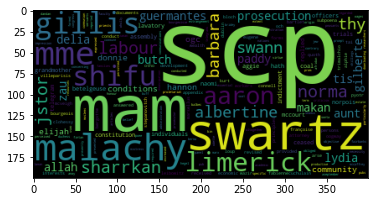

In [92]:
data = df.transpose()
data.columns = ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2020']
wordcloud = WordCloud().generate_from_frequencies(data['1970-1979'])
plt.imshow(wordcloud)

In [52]:
lyrics1 = " "
df1 = lyric_data[lyric_data['class'] == 1]
for i,row in df1.iterrows():
    if row['lyrics'] != 0:
        lyrics1 += row['lyrics']
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(lyrics1)

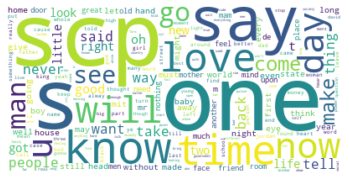

In [53]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
#print(lyric_data.loc[2,'lyrics'].split())